In [12]:
# Importing the libraries we'll be using for this project
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, RocCurveDisplay,f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.utils.class_weight import compute_class_weight


In [19]:
# load in database and split as neccessary
df = pd.read_csv('database_prev7days.csv')
df = df[df.Diff != 0]
print(df.shape)
# Splitting the training data into appropriate training and validation sets
X = df.drop(columns = ["Diff","date","Unnamed: 0"])
print(df.head(2))
y = df[['Diff']]
y = y.to_numpy().flatten()
weights = compute_class_weight(class_weight='balanced',classes = np.unique(y),y = y)

X_train, X_val, y_train, y_val = train_test_split(X, y, random_state = 42,stratify=y)# makes sure train test splitting are the imbalanced by the same amount

(982, 59)
   Unnamed: 0      date  pos_mean_replies  pos_mean_retweet  neu_mean_likes  \
0           0  20170109          0.552184          0.598106        2.431541   
1           1  20170110          2.973540          3.970256        4.156664   

   neu_mean_replies  neu_mean_retweet  neg_mean_likes  neg_mean_replies  \
0          2.477603          2.434837        0.209339          0.196020   
1          5.277351          4.300867        0.074348          0.082443   

   neg_mean_retweet  ...  neg_mean_retweet.5  pos_mean_replies.6  \
0          0.192863  ...            1.255735            3.828412   
1          0.062210  ...            4.210966            6.260311   

   pos_mean_retweet.6  neu_mean_likes.6  neu_mean_replies.6  \
0            3.232838          8.028677            8.366872   
1            5.908047          6.780715            7.166920   

   neu_mean_retweet.6  neg_mean_likes.6  neg_mean_replies.6  \
0            9.094131          0.264051            0.304716   
1    

In [6]:
def cv_fit_search(pipeline, param_grid, X_train,y_train,X_test,y_test,cv):
    """ a function to fit the data and do hyper parameter tuning
    Args:
        pipeline: a predefined pipeline
        param grid: a list of parameters that match the pipeline naming convetion
        CV: integer indicating the number of cross validations we want to do
        X_train:X to train on
        y_train: labels for Training Set
        X_test = held out data for final accuacry
        y_test = held out labels
    
    Return
    model: the fitted and hypertuned model,
    
    Prints: AUROC Curve, ACC AUC score of best models, best parameters found

    """
    grid_search = GridSearchCV(pipeline, param_grid, cv=cv, verbose=0,n_jobs=-1) # sets cross calidation settings
    grid_search.fit(X_train,y_train.ravel())

    pipeline_preds = grid_search.predict(X_test)
    val_accuracy = accuracy_score(y_test, pipeline_preds)
    val_roc_auc = roc_auc_score(y_test, pipeline_preds)
    f1 = f1_score(y_test, pipeline_preds)
    
    print("the best parametes are",grid_search.best_params_)
    print(f'Accuracy Score: {val_accuracy}')
    print(f'ROC AUC Score: {val_roc_auc}') 
    print(f'f1 Score: {f1}') 

    RocCurveDisplay.from_predictions(y_test, pipeline_preds)
    plt.show()
    return grid_search

the best parametes are {'model__criterion': 'gini', 'model__max_depth': 40, 'model__min_samples_leaf': 6, 'model__min_samples_split': 6, 'model__n_estimators': 90}
Accuracy Score: 0.4796747967479675
ROC AUC Score: 0.4718150319829424
f1 Score: 0.5395683453237411


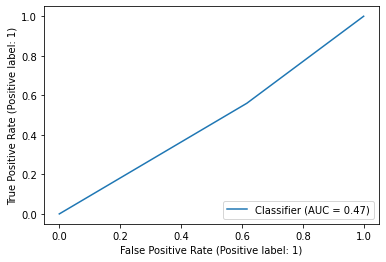

['model/randomforest_pipeline.pkl']

In [21]:
#Create a random forest pipeline
randomforest_pipeline = Pipeline(steps = [
    ('data_scaling', StandardScaler()),
    ('model', RandomForestClassifier(class_weight= "balanced"))
])
randomforest_param_grid = [
    {
        "model__n_estimators": np.arange(30,100,15),
        "model__criterion": ["gini","entropy"],
        "model__max_depth": np.arange(10,100,30),
        "model__min_samples_leaf": [3,6],
        "model__min_samples_split": [3,6]
        
    }
] 
tuned_model = cv_fit_search(randomforest_pipeline,randomforest_param_grid,X_train,y_train,X_val,y_val,10)
joblib.dump(tuned_model, 'model/randomforest_pipeline.pkl')

the best parametes are {'model__l2_regularization': 1, 'model__learning_rate': 0.01, 'model__loss': 'binary_crossentropy'}
Accuracy Score: 0.524390243902439
ROC AUC Score: 0.50772921108742
f1 Score: 0.613861386138614


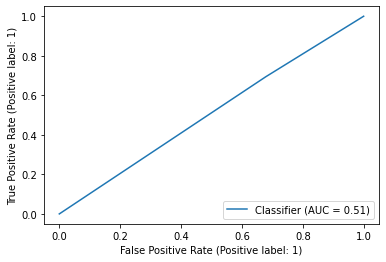

['model/boosting_pipeline.pkl']

In [7]:
# Lets try a boosting model now
# Due to the way boosting works, does not need weights to deal with imbalanced classes
from sklearn.ensemble import HistGradientBoostingClassifier
boostingPipeline = Pipeline(steps = [
    ('data_scaling', StandardScaler()),
    ('model', HistGradientBoostingClassifier())
])

boosting_param_grid = [
    {
        "model__loss": ["binary_crossentropy","auto"],
        "model__learning_rate": [0.01,0.05,0.1,0.5,1],
        "model__l2_regularization": [0,1]
    }
]   
tuned_model = cv_fit_search(boostingPipeline,boosting_param_grid,X_train,y_train,X_val,y_val,10)
joblib.dump(tuned_model, 'model/boosting_pipeline.pkl')

the best parametes are {'model__penalty': 'l1'}
Accuracy Score: 0.491869918699187
ROC AUC Score: 0.48740671641791045
f1 Score: 0.5353159851301115


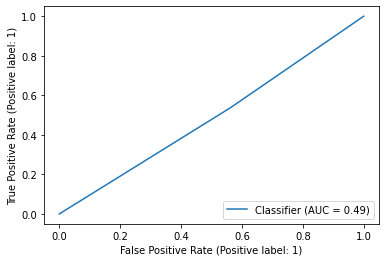

['model/lr_pipeline.pkl']

In [23]:
#logistic Regression with cross validation
from sklearn.linear_model import LogisticRegressionCV
lr_pipeline = Pipeline(steps = [
    ('data_scaling', StandardScaler()),
    ('model', LogisticRegressionCV(solver="liblinear",class_weight="balanced"))#saga solver works for all penalties
])

lr_param_grid = [
    {
        "model__penalty": ['l1', 'l2']
    }
]

tuned_model = cv_fit_search(lr_pipeline,lr_param_grid,X_train,y_train,X_val,y_val,10)
joblib.dump(tuned_model, 'model/lr_pipeline.pkl')

the best parametes are {'model__n_neighbors': 192}
Accuracy Score: 0.532520325203252
ROC AUC Score: 0.48856951871657756


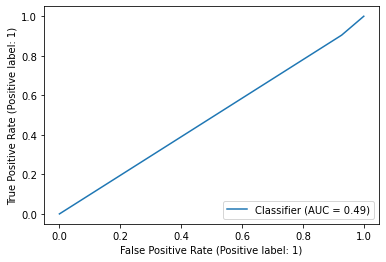

['model/knnc_pipeline.pkl']

In [30]:
#k nearest neighbors classifier
from sklearn.neighbors import KNeighborsClassifier

knnc_pipeline = Pipeline(steps = [
    ('data_scaling', StandardScaler()),
    ('model', KNeighborsClassifier(classw))#10 cross validation
])

knnc_param_grid = [
    {
        "model__n_neighbors": np.arange(1,200)
    }
]

tuned_model = cv_fit_search(knnc_pipeline,knnc_param_grid,X_train,y_train,X_val,y_val,10)

joblib.dump(tuned_model, 'model/knnc_pipeline.pkl')


the best parametes are {'model__kernel': 'rbf'}
Accuracy Score: 0.5487804878048781
ROC AUC Score: 0.5205890191897655
f1 Score: 0.6686567164179105


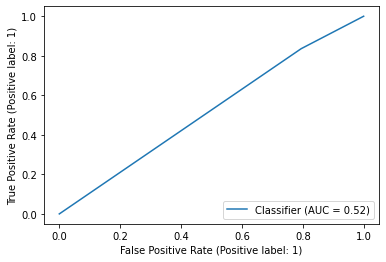

['model/svm_pipeline.pkl']

In [24]:
from sklearn.svm import SVC

svm_pipeline = Pipeline(steps = [
    ('data_scaling', StandardScaler()),
    ('model', SVC(class_weight="balanced"))#10 cross validation
])

svm_param_grid = [
    {
        "model__kernel": ['linear', 'poly', 'rbf']
    }
]

tuned_model = cv_fit_search(svm_pipeline,svm_param_grid,X_train,y_train,X_val,y_val,10)

joblib.dump(tuned_model, 'model/svm_pipeline.pkl')